In [0]:
# Importación de librerias
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import re
from unicodedata import normalize
from itertools import chain
import handyspark as hdy
import matplotlib.pyplot as plt
import seaborn as sns
from sparkdl.xgboost import XgboostClassifier

from pyspark.sql.types import StringType
from pyspark.ml.linalg import Vectors
from pyspark.ml.functions import vector_to_array
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, VectorSizeHint
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import StructType,StructField, StringType, IntegerType, LongType, BooleanType, DoubleType, TimestampType
from pyspark.sql.functions import desc, length, col,isnan,when,count
import pyspark.sql.functions as F

import mlflow
import mlflow.spark

from hyperopt import fmin, tpe, hp, SparkTrials, Trials, STATUS_OK
from hyperopt.pyll import scope
from math import exp
from mlflow.models.signature import infer_signature
from sklearn.metrics import roc_auc_score, balanced_accuracy_score, confusion_matrix, classification_report, confusion_matrix

In [0]:
# Parámetros para enlazar al Storage Account
# storage_account = "blobName"
# container = "basecruzada"
# blobKey = "blobKey"
# blobEndpoint = "wasbs://{1}@{0}.blob.core.windows.net/".format(storage_account, container)

# try:
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})
# except:
#   print("Already mounted. Unmounting and trying to mount again")
#   dbutils.fs.unmount(mount_point='/mnt/basecruzada')
#   dbutils.fs.mount(
#     source = blobEndpoint,
#     mount_point = "/mnt/basecruzada",
#     extra_configs = {"fs.azure.account.key.{0}.blob.core.windows.net".format(storage_account):blobKey})

In [0]:
# Leer archivo parquet donde se encuentra la base limpia
file = "/mnt/basecruzada/baselimpia"
DF_modelo = spark.read.parquet(file)

In [0]:
# Filtrar datos para que solo contengan información de mayo 2020 para atrás, fecha de corte definida para los datos de entrenamiento del modelo. Esto porque los datos fueron recolectados con fecha de corte mayo de 2021, y se tomó como criterio que debía trascurrir un año para que el posible proceso de una petición complete su curso (por ejemplo, si llega hasta el punto de la apertura de un Proceso Administrativo de Restablecimiento de Derechos - PARD)  
print((DF_modelo.count(), len(DF_modelo.columns)))
DF_modelo = DF_modelo.filter((col("AnoRegistroPeticion") != "2021"))
print((DF_modelo.count(), len(DF_modelo.columns)))
DF_modelo = DF_modelo.filter((col("AnoRegistroPeticion") != "2020") | ~(col("MesRegistroPeticion").isin(["Jun", "Jul", "Aug", "Sep", "Oct","Nov","Dec"])))
print((DF_modelo.count(), len(DF_modelo.columns)))

(1163243, 118)
(1088405, 118)
(982085, 118)

In [0]:
# Se seleccionan columnas que permanecen para el entrenamiento del modelo
columnas_mantener = ['AnoRegistroPeticion', 'horaRegistroPeticion', 'minutoRegistroPeticion', 'X', 'Y', 'porc_etnica_2018', 'porc_indigena_2018', 'tasa_vip_total', 'tasa_vif_total', 'TasaFecunidad_15a19', 'porc_rural', 'vict_delsexual_total', 'EdadAfectado_Anios_Imputada', 'MesRegistroPeticion', 'MotivoPeticion', "TipoPeticion", 'CanalRecepcion','TipoDocumentoPeticionario', 'EdadPeticionario', 'SexoPeticionario', "DetalleZonaPeticionario", 'TipoDocumentoAfectado', 'SexoAfectado', "DetalleZonAfectado", 'GrupoEtnicoAfectado', 'PresentaDiscapacidadAfectado', 'CondicionDesplazamientoAfectado', 'PaisAfectado_5', "CategorizacionPeticionario", "SinSuficienteInfo_Afectado", 'DescripcionPeticion', 'VAR_OBJETIVO']

DF_modelo = DF_modelo.select(columnas_mantener)

In [0]:
# Se convierte de forma manual la variable objetivo como variable numérica, de forma que se pueda controlar cuál número se asigna a cada categoría
dicc_varoobj = {"falsa": 0, "sindefinir_fallida":1, "verdadera_nopard":2, "verdadera_pard_noinst":3, "verdadera_pard_inst":4}

# Crea en Spark un mapeo de los keys del diccionario a los values
print(DF_modelo.groupby("VAR_OBJETIVO").count().sort("count", ascending=False).show())
mapping_expr = F.create_map([F.lit(x) for x in chain(*dicc_varoobj.items())])
DF_modelo = DF_modelo.withColumn("VAR_OBJETIVO", mapping_expr[col("VAR_OBJETIVO")])
print(DF_modelo.groupby("VAR_OBJETIVO").count().sort("count", ascending=False).show())

+--------------------+------+
 VAR_OBJETIVO| count|
+--------------------+------+
 verdadera_nopard|307642|
 falsa|304135|
 sindefinir_fallida|170111|
verdadera_pard_no...|137667|
 verdadera_pard_inst| 62530|
+--------------------+------+

None
+------------+------+
VAR_OBJETIVO| count|
+------------+------+
 2|307642|
 0|304135|
 1|170111|
 3|137667|
 4| 62530|
+------------+------+

None

In [0]:
# Checkear por nulos
series_nulos = DF_modelo.toHandy().isnull(ratio=False)
series_nulos

Out[9]: AnoRegistroPeticion 0
horaRegistroPeticion 0
minutoRegistroPeticion 0
X 0
Y 0
porc_etnica_2018 0
porc_indigena_2018 0
tasa_vip_total 0
tasa_vif_total 0
TasaFecunidad_15a19 0
porc_rural 0
vict_delsexual_total 0
EdadAfectado_Anios_Imputada 0
MesRegistroPeticion 0
MotivoPeticion 0
TipoPeticion 0
CanalRecepcion 0
TipoDocumentoPeticionario 0
EdadPeticionario 0
SexoPeticionario 0
DetalleZonaPeticionario 0
TipoDocumentoAfectado 0
SexoAfectado 0
DetalleZonAfectado 0
GrupoEtnicoAfectado 0
PresentaDiscapacidadAfectado 0
CondicionDesplazamientoAfectado 0
PaisAfectado_5 0
CategorizacionPeticionario 0
SinSuficienteInfo_Afectado 0
DescripcionPeticion 29
VAR_OBJETIVO 0
Name: missing, dtype: int64

In [0]:
# Debido a que en el conjunto de datos hay algunos campos nulos en la DescripcionPeticion, es necesario eliminar estos registros para el entrenamiento del modelo
DF_modelo = DF_modelo.na.drop()
total_count = DF_modelo.count()
print(total_count)
DF_modelo.groupBy("VAR_OBJETIVO").count().withColumn('percentage', F.round((col("count")/float(total_count))*100, 1)).sort("VAR_OBJETIVO").show()

982056
+------------+------+----------+
VAR_OBJETIVO| count|percentage|
+------------+------+----------+
 0|304128| 31.0|
 1|170102| 17.3|
 2|307632| 31.3|
 3|137666| 14.0|
 4| 62528| 6.4|
+------------+------+----------+

In [0]:
# Muestreo estratificado para crear datos train, test y validation. Entrenamiento 80%, Evaluación 20%. Luego, del conjunto de Entrenamiento se toma el 10% de los datos como conjunto de Validación. En conclusión, el 100% de los datos se reparte en Entrenamiento 72%, Validación 8%, Evaluación 20%
train_sdf = DF_modelo.sampleBy("VAR_OBJETIVO", fractions={0: 0.8, 1: 0.8, 2:0.8, 3:0.8, 4:0.8}, seed=5)
test_sdf = DF_modelo.subtract(train_sdf)
val_sdf = train_sdf.sampleBy("VAR_OBJETIVO", fractions={0: 0.1, 1: 0.1, 2:0.1, 3:0.1, 4:0.1}, seed=5)
train_sdf = train_sdf.subtract(val_sdf)

# El paquete de XGBoost de Spark requiere que el set de Train y de Val esten en el mismo Dataframe, pero que sean identificados mediante una columna con valores booleanos (True -> Validation, False -> Training)
train_sdf = train_sdf.withColumn("isVal", F.lit(False))
val_sdf = val_sdf.withColumn("isVal", F.lit(True))
train_sdf = train_sdf.unionByName(val_sdf)

# Mostrar el conteo y la frecuencia relativa de los datos de Entrenamiento
train_count = train_sdf.filter(col("isVal")==F.lit(False)).count()
print("Total registros de entrenamiento: ", train_count)
freq_train = train_sdf.filter(col("isVal")==F.lit(False)).groupBy("VAR_OBJETIVO").count().withColumn('percentage', F.round((col("count")/float(train_count))*100, 1)).sort("VAR_OBJETIVO")
freq_train.show()

# Mostrar el conteo y la frecuencia relativa de los datos de Validación
val_count = train_sdf.filter(col("isVal")==F.lit(True)).count()
print("Total registros de validación: ", val_count)
val_sdf.filter(col("isVal")==F.lit(True)).groupBy("VAR_OBJETIVO").count().withColumn('percentage', F.round((col("count")/float(val_count))*100, 1)).sort("VAR_OBJETIVO").show()

# Mostrar el conteo y la frecuencia relativa de los datos de Evaluación/Testeo
test_count = test_sdf.count()
print("Total registros de testeo: ", test_count)
test_sdf.groupBy("VAR_OBJETIVO").count().withColumn('percentage', F.round((col("count")/float(test_count))*100, 1)).sort("VAR_OBJETIVO").show()

Total registros de entrenamiento: 707314
+------------+------+----------+
VAR_OBJETIVO| count|percentage|
+------------+------+----------+
 0|219094| 31.0|
 1|122368| 17.3|
 2|221744| 31.4|
 3| 99026| 14.0|
 4| 45082| 6.4|
+------------+------+----------+

Total registros de validación: 78129
+------------+-----+----------+
VAR_OBJETIVO|count|percentage|
+------------+-----+----------+
 0|24173| 30.9|
 1|13652| 17.5|
 2|24300| 31.1|
 3|11074| 14.2|
 4| 4930| 6.3|
+------------+-----+----------+

Total registros de testeo: 196560
+------------+-----+----------+
VAR_OBJETIVO|count|percentage|
+------------+-----+----------+
 0|60847| 31.0|
 1|34076| 17.3|
 2|61567| 31.3|
 3|27559| 14.0|
 4|12511| 6.4|
+------------+-----+----------+

In [0]:
# Identificar el conjunto de variables que son de categóricas y vienen como tipo texto
string_columns = [fld.name for fld in train_sdf.schema.fields if isinstance(fld.dataType, StringType) if fld.name!="DescripcionPeticion"]
print(string_columns)

['MesRegistroPeticion', 'MotivoPeticion', 'TipoPeticion', 'CanalRecepcion', 'TipoDocumentoPeticionario', 'EdadPeticionario', 'SexoPeticionario', 'DetalleZonaPeticionario', 'TipoDocumentoAfectado', 'SexoAfectado', 'DetalleZonAfectado', 'GrupoEtnicoAfectado', 'PresentaDiscapacidadAfectado', 'CondicionDesplazamientoAfectado', 'PaisAfectado_5', 'CategorizacionPeticionario', 'SinSuficienteInfo_Afectado']

In [0]:
# A cada categoría de las variables categóricas primero se les asigna un número (StringIndexer) y luego se hace one-hot encoding sobre esta (OneHotEncoder)
string_col_indexer = [fld + "_ix" for fld in string_columns]
string_col_onehot = [fld + "_ohe" for fld in string_columns]
string_column_map=list(zip(string_columns, string_col_indexer, string_col_onehot))
print(string_column_map)

[('MesRegistroPeticion', 'MesRegistroPeticion_ix', 'MesRegistroPeticion_ohe'), ('MotivoPeticion', 'MotivoPeticion_ix', 'MotivoPeticion_ohe'), ('TipoPeticion', 'TipoPeticion_ix', 'TipoPeticion_ohe'), ('CanalRecepcion', 'CanalRecepcion_ix', 'CanalRecepcion_ohe'), ('TipoDocumentoPeticionario', 'TipoDocumentoPeticionario_ix', 'TipoDocumentoPeticionario_ohe'), ('EdadPeticionario', 'EdadPeticionario_ix', 'EdadPeticionario_ohe'), ('SexoPeticionario', 'SexoPeticionario_ix', 'SexoPeticionario_ohe'), ('DetalleZonaPeticionario', 'DetalleZonaPeticionario_ix', 'DetalleZonaPeticionario_ohe'), ('TipoDocumentoAfectado', 'TipoDocumentoAfectado_ix', 'TipoDocumentoAfectado_ohe'), ('SexoAfectado', 'SexoAfectado_ix', 'SexoAfectado_ohe'), ('DetalleZonAfectado', 'DetalleZonAfectado_ix', 'DetalleZonAfectado_ohe'), ('GrupoEtnicoAfectado', 'GrupoEtnicoAfectado_ix', 'GrupoEtnicoAfectado_ohe'), ('PresentaDiscapacidadAfectado', 'PresentaDiscapacidadAfectado_ix', 'PresentaDiscapacidadAfectado_ohe'), ('CondicionDesplazamientoAfectado', 'CondicionDesplazamientoAfectado_ix', 'CondicionDesplazamientoAfectado_ohe'), ('PaisAfectado_5', 'PaisAfectado_5_ix', 'PaisAfectado_5_ohe'), ('CategorizacionPeticionario', 'CategorizacionPeticionario_ix', 'CategorizacionPeticionario_ohe'), ('SinSuficienteInfo_Afectado', 'SinSuficienteInfo_Afectado_ix', 'SinSuficienteInfo_Afectado_ohe')]

In [0]:
# Definir cuáles son las variables predictoras del modelo, que son las variables numéricas (not StringType) + categóricas (one hot encoded) + features creadas a partir del texto (embeddings) 
predictors = [fld.name for fld in train_sdf.schema.fields if not isinstance(fld.dataType, StringType) if fld.name!="VAR_OBJETIVO" if fld.name!="isVal" if fld.name!="weights"] + string_col_onehot + ["finished_embeddings_vector"] 
print(predictors)

['AnoRegistroPeticion', 'horaRegistroPeticion', 'minutoRegistroPeticion', 'X', 'Y', 'porc_etnica_2018', 'porc_indigena_2018', 'tasa_vip_total', 'tasa_vif_total', 'TasaFecunidad_15a19', 'porc_rural', 'vict_delsexual_total', 'EdadAfectado_Anios_Imputada', 'MesRegistroPeticion_ohe', 'MotivoPeticion_ohe', 'TipoPeticion_ohe', 'CanalRecepcion_ohe', 'TipoDocumentoPeticionario_ohe', 'EdadPeticionario_ohe', 'SexoPeticionario_ohe', 'DetalleZonaPeticionario_ohe', 'TipoDocumentoAfectado_ohe', 'SexoAfectado_ohe', 'DetalleZonAfectado_ohe', 'GrupoEtnicoAfectado_ohe', 'PresentaDiscapacidadAfectado_ohe', 'CondicionDesplazamientoAfectado_ohe', 'PaisAfectado_5_ohe', 'CategorizacionPeticionario_ohe', 'SinSuficienteInfo_Afectado_ohe', 'finished_embeddings_vector']

In [0]:
# Se carga el pipeline entrenado en el cuadernillo "3_PipelineSpark_TFIDF_Embedding", el correspondiente al Word Embedding que genera 100 features/variables 
pipeline_wemb = mlflow.spark.load_model("runs:/abd6d3995aaf4c65b2577b73a9be62cf/word_embedding_text_featuriser")

2021/09/27 15:14:59 INFO mlflow.spark: 'runs:/abd6d3995aaf4c65b2577b73a9be62cf/word_embedding_text_featuriser' resolved as 'dbfs:/databricks/mlflow-tracking/3030803122807175/abd6d3995aaf4c65b2577b73a9be62cf/artifacts/word_embedding_text_featuriser'
2021/09/27 15:15:00 INFO mlflow.spark: File 'dbfs:/databricks/mlflow-tracking/3030803122807175/abd6d3995aaf4c65b2577b73a9be62cf/artifacts/word_embedding_text_featuriser/sparkml' not found on DFS. Will attempt to upload the file.
2021/09/27 15:16:02 INFO mlflow.spark: Copied SparkML model to /tmp/mlflow/2338a52d-2924-4699-b3b1-87eb27999d25

In [0]:
# Se transforma en features el texto contenido en DescripcionPetición mediante el Pipeline de Word Embedding importado en la celda anterior
columnas_mantener_2 = columnas_mantener + ['finished_embeddings_vector']
DF_modelo = pipeline_wemb.transform(DF_modelo).select(columnas_mantener_2)

In [0]:
# Se guarda el pipeline que contiene la indexización de las variables categóricas (SringIndexer) para su posterior transformación en one-hot encoded (OneHotEncoder), y luego todas las variables predictoras (predictors) se compactan en un solo vector (VectorAssembler) como se hace en el entrenamiento de modelos de ML con Spark. El paso de sizeHint es necesario para decir cuál es el tamaño del vector de features que salen del texto (en este caso es de 100 features a partir del Word Embedding) y que no surjan errores en el paso de VectorAssembler
si = [StringIndexer(inputCol=fld[0], outputCol=fld[1], handleInvalid="keep") for fld in string_column_map]
ohe = [OneHotEncoder(inputCol=fld[1], outputCol=fld[2], handleInvalid="keep") for fld in string_column_map]
sizeHint = VectorSizeHint(inputCol="finished_embeddings_vector", size=100, handleInvalid="skip")
va = VectorAssembler(inputCols=predictors, outputCol="features", handleInvalid="skip")
pipeline = Pipeline(stages=[*si, *ohe, sizeHint, va])

In [0]:
# Se realiza el fit del pipeline de la celda anterior con base a los datos completos
fitted_pipeline = pipeline.fit(DF_modelo)

In [0]:
# Se hace transformación de los datos de entrenamiento y evaluación conforme al pipeline definido
train_sdf = pipeline_wemb.transform(train_sdf).select(columnas_mantener_2 + ["isVal"])
train_sdf = fitted_pipeline.transform(train_sdf)

test_sdf = pipeline_wemb.transform(test_sdf).select(columnas_mantener_2)
test_sdf = fitted_pipeline.transform(test_sdf)

In [0]:
# Este modelo se va a entrenar con pesos diferentes para cada una de las categorías, debido al desbalance en la ocurrencia de las categorías (Ej: la categoría Verdadero no PARD -0- es el 31.4% de los registros, mientras que solo el 6.4% de los registros son Verdadero PARD Institucional). De esta manera el peso es inverso a la frecuencia que tiene la categoría (entre más infrecuente, mayor peso tiene)
df_freq_rel = freq_train.select("VAR_OBJETIVO", "percentage")
dict_freq = df_freq_rel.toPandas().set_index('VAR_OBJETIVO').T.to_dict('records')[0]
inv_dict = {k: 1 / v for k, v in dict_freq.items()}
print(dict_freq)
print(inv_dict)

{0: 31.0, 1: 17.3, 2: 31.4, 3: 14.0, 4: 6.4}
{0: 0.03225806451612903, 1: 0.057803468208092484, 2: 0.03184713375796178, 3: 0.07142857142857142, 4: 0.15625}

In [0]:
# Una vez calculados los pesos en inv_dict, se crea una columna "weights" que contiene el peso para cada observación de acuerdo a la categoría de la Variable Objetivo
mapping_expr = F.create_map([F.lit(x) for x in chain(*inv_dict.items())])
train_sdf = train_sdf.withColumn("weights", mapping_expr[col("VAR_OBJETIVO")])
test_sdf = test_sdf.withColumn("weights", mapping_expr[col("VAR_OBJETIVO")])

In [0]:
# Una vez ya se tienen todas las features en un sola columna/vector no es necesario mantener las variables individuales, de forma que aquí se conservan solo las cuatro columnas necesarias para el entrenamiento de los Gradient Boosted Trees con XGBoost
train_sdf_prepared = train_sdf.select("features", "VAR_OBJETIVO", "weights", "isVal")
test_sdf_prepared = test_sdf.select("features", "VAR_OBJETIVO", "weights")

In [0]:
# Se guardan los datos que entrarán al entrenamiento de los modelos de XGBoost, de forma que el entrenamiento no tarde tanto al Spark realizar todo el preprocesamiento de los datos en cada uno de los modelos
train_sdf_prepared.write.mode("overwrite").parquet("/mnt/basecruzada/train_data_wembd")
test_sdf_prepared.write.mode("overwrite").parquet("/mnt/basecruzada/test_data_wembd")

In [0]:
# Se leen de nuevo los datos de Entrenamiento y Evaluación guardados en la celda anterior
file_train = "/mnt/basecruzada/train_data_wembd"
train_sdf_prepared = spark.read.parquet(file_train)

file_test = "/mnt/basecruzada/test_data_wembd"
test_sdf_prepared = spark.read.parquet(file_test)

In [0]:
# Se envían a cache los datos, de forma que el entrenamiento también sea más rapido
train_sdf_prepared.cache()
test_sdf_prepared.cache()
train_sdf_prepared.count()
test_sdf_prepared.count()

Out[5]: 196560

In [0]:
# Aquí se define el espacio para la búsqueda de hiperparámetros de XGBOoost con HyperOpt.
spark_model_name = "xgboost_weights_embedding"

search_space = {
  'max_depth': scope.int(hp.quniform('max_depth', 4, 12, 1)),
  'eta': hp.loguniform('eta', -3, 0),
  'reg_alpha': hp.uniform('reg_alpha', 0, 1),
  'reg_lambda': hp.uniform('reg_lambda', 0, 1),
  'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
  'subsample': hp.uniform('subsample', 0.5, 1),
  'objective': 'multi:softmax',
  'seed': 5,
  "missing":0.0,
  "num_class": 5,
  "num_round": 1000,
  "num_workers": 3,
  "tree_method" : "gpu_hist",
  "use_gpu": True,
  "verbosity":2,
  "random_state":5
}

In [0]:
# Se define una función que HyperOpt utilizará para entrenar distintos modelos de XGBoost con distintas combinaciones de hiperparámetros.
# Dentro del modelo de XgboostClassifier se define cuál es la columna del dataframe que contiene las features (featuresCol), la variable objetivo (labelCol), la columna de pesos (weightCol), la columna que indica si la observación es de Entrenamiento o Validación (validationIndicatorCol). También se define allí el nombre de las dos columnas que resultarán al hacer el predict con el modelo entrenado, "prediction" que contendrá la categoría predicha y "probability" que es un vector de tamaño 5 en el que está la probabilidad asignada a cada categoría del modelo
# MLflow se empleará para hacer un registro de los modelos entrenados, los hiperparámetros usados para cada uno y las métricas calculadas sobre el conjunto de Evaluación para cada modelo y así poderlos comparar posteriormente
def train_model(xgbParams):
  with mlflow.start_run(nested=True):
    print("Start training")
    xgb = (
      XgboostClassifier(**xgbParams, featuresCol="features", labelCol="VAR_OBJETIVO", weightCol='weights', validationIndicatorCol='isVal', 
                        early_stopping_rounds=50, predictionCol="prediction",
                        probabilityCol="probability", eval_metric=["mlogloss"])
    )
    model = xgb.fit(train_sdf_prepared)
    mlflow.spark.log_model(model, "xgboost_weights_embedding")
    
    mlflow.log_param("hyper-parameters", xgbParams)
    mlflow.log_param("max_depth", xgbParams["max_depth"])
    mlflow.log_param("eta", xgbParams["eta"])
    mlflow.log_param("reg_alpha", xgbParams["reg_alpha"])
    mlflow.log_param("reg_lambda", xgbParams["reg_lambda"])
    mlflow.log_param("min_child_weight", xgbParams["min_child_weight"])
    mlflow.log_param("subsample", xgbParams["subsample"])
    
    print("Start predict")
    result = model.transform(test_sdf_prepared)
    result_pd = result.select("VAR_OBJETIVO", "prediction").toPandas()
    result_pd.to_csv("results.csv", index=False, sep="|")
    mlflow.log_artifact("results.csv")
    
    print("Start metrics")
    target_names = ["falsa", "sindefinir_fallida", "verdadera_nopard", "verdadera_pard_noinst", "verdadera_pard_inst"]
    print_classif = classification_report(result_pd["VAR_OBJETIVO"], result_pd["prediction"], output_dict=True,target_names=target_names)
    acc = print_classif["accuracy"]
    print(acc)
    metrics = dict(avg_recall = print_classif["macro avg"]["recall"], avg_f1score = print_classif["macro avg"]["f1-score"], 
                   acc = print_classif["accuracy"], falsa_recall = print_classif["falsa"]["recall"],
                   sindef_recall = print_classif["sindefinir_fallida"]["recall"], verdnopard_recall = print_classif["verdadera_nopard"]["recall"],
                   pardnoinst_recall = print_classif["verdadera_pard_noinst"]["recall"], pardinst_recall = print_classif["verdadera_pard_inst"]["recall"],
                   falsa_f1score = print_classif["falsa"]["f1-score"], sindef_f1score = print_classif["sindefinir_fallida"]["f1-score"], 
                   verdnopard_f1score = print_classif["verdadera_nopard"]["f1-score"], pardnoinst_f1score = print_classif["verdadera_pard_noinst"]["f1-score"],
                   pardinst_f1score = print_classif["verdadera_pard_inst"]["f1-score"]
                  )
    mlflow.log_metrics(metrics)
    
    return {'status': STATUS_OK, 'loss': -1*acc}
  
spark_trials = Trials()

# Con HyperOpt se define el espacio sobre el que se hará la búsqueda de hiperparámetros y se define que máximo se evalúen 50 diferentes modelos
with mlflow.start_run(run_name='xgboost_weights_embedding'):
  best_params = fmin(
    fn=train_model, 
    space=search_space, 
    algo=tpe.suggest, 
    max_evals=50,
    trials=spark_trials, 
    rstate=np.random.RandomState(5)
  )
print(best_params)

0%| | 0/50 [00:00<?, ?trial/s, best loss=?] Start training
 0%| | 0/50 [00:00<?, ?trial/s, best loss=?] Start predict
 0%| | 0/50 [23:44<?, ?trial/s, best loss=?] Start metrics
 0%| | 0/50 [24:06<?, ?trial/s, best loss=?] 0.3681776556776557
 0%| | 0/50 [24:06<?, ?trial/s, best loss=?] 2%|▏ | 1/50 [24:07<19:41:54, 1447.23s/trial, best loss: -0.3681776556776557] Start training
 2%|▏ | 1/50 [24:07<19:41:54, 1447.23s/trial, best loss: -0.3681776556776557] Start predict
 2%|▏ | 1/50 [30:27<19:41:54, 1447.23s/trial, best loss: -0.3681776556776557] Start metrics
 2%|▏ | 1/50 [30:43<19:41:54, 1447.23s/trial, best loss: -0.3681776556776557] 0.3736874236874237
 2%|▏ | 1/50 [30:43<19:41:54, 1447.23s/trial, best loss: -0.3681776556776557] 4%|▍ | 2/50 [30:43<11:03:19, 829.16s/trial, best loss: -0.3736874236874237]  Start training
 4%|▍ | 2/50 [30:44<11:03:19, 829.16s/trial, best loss: -0.3736874236874237] Start predict
 4%|▍ | 2/50 [35:48<11:03:19, 829.16s/trial, best loss: -0.3736874236874237] Start metrics
 4%|▍ | 2/50 [36:03<11:03:19, 829.16s/trial, best loss: -0.3736874236874237] 0.3366605616605617
 4%|▍ | 2/50 [36:04<11:03:19, 829.16s/trial, best loss: -0.3736874236874237] 6%|▌ | 3/50 [36:04<7:47:37, 596.97s/trial, best loss: -0.3736874236874237]  Start training
 6%|▌ | 3/50 [36:04<7:47:37, 596.97s/trial, best loss: -0.3736874236874237] Start predict
 6%|▌ | 3/50 [47:21<7:47:37, 596.97s/trial, best loss: -0.3736874236874237] Start metrics
 6%|▌ | 3/50 [47:39<7:47:37, 596.97s/trial, best loss: -0.3736874236874237] 0.3771927146927147
 6%|▌ | 3/50 [47:39<7:47:37, 596.97s/trial, best loss: -0.3736874236874237] 8%|▊ | 4/50 [47:39<8:07:27, 635.82s/trial, best loss: -0.3771927146927147] Start training
 8%|▊ | 4/50 [47:40<8:07:27, 635.82s/trial, best loss: -0.3771927146927147] Start predict
 8%|▊ | 4/50 [1:08:20<8:07:27, 635.82s/trial, best loss: -0.3771927146927147] Start metrics
 8%|▊ | 4/50 [1:08:40<8:07:27, 635.82s/trial, best loss: -0.3771927146927147] 0.3635785510785511
 8%|▊ | 4/50 [1:08:40<8:07:27, 635.82s/trial, best loss: -0.3771927146927147] 10%|█ | 5/50 [1:08:40<10:45:55, 861.24s/trial, best loss: -0.3771927146927147] Start training
 10%|█ | 5/50 [1:08:41<10:45:55, 861.24s/trial, best loss: -0.3771927146927147] Start predict
 10%|█ | 5/50 [1:23:07<10:45:55, 861.24s/trial, best loss: -0.3771927146927147] Start metrics
 10%|█ | 5/50 [1:23:25<10:45:55, 861.24s/trial, best loss: -0.3771927146927147] 0.3256817256817257
 10%|█ | 5/50 [1:23:25<10:45:55, 861.24s/trial, best loss: -0.3771927146927147] 12%|█▏ | 6/50 [1:23:25<10:37:33, 869.40s/trial, best loss: -0.3771927146927147] Start training
 12%|█▏ | 6/50 [1:23:26<10:37:33, 869.40s/trial, best loss: -0.3771927146927147] Start predict
 12%|█▏ | 6/50 [2:15:52<10:37:33, 869.40s/trial, best loss: -0.3771927146927147] Start metrics
 12%|█▏ | 6/50 [2:16:27<10:37:33, 869.40s/trial, best loss: -0.3771927146927147] 0.36984635734635735
 12%|█▏ | 6/50 [2:16:27<10:37:33, 869.40s/trial, best loss: -0.3771927146927147] 14%|█▍ | 7/50 [2:16:28<19:24:56, 1625.51s/trial, best loss: -0.3771927146927147] Start training
 14%|█▍ | 7/50 [2:16:28<19:24:56, 1625.51s/trial, best loss: -0.3771927146927147] Start predict
 14%|█▍ | 7/50 [2:26:18<19:24:56, 1625.51s/trial, best loss: -0.3771927146927147] Start metrics
 14%|█▍ | 7/50 [2:26:35<19:24:56, 1625.51s/trial, best loss: -0.3771927146927147] 0.35803825803825806
 14%|█▍ | 7/50 [2:26:35<19:24:56, 1625.51s/trial, best loss: -0.3771927146927147] 16%|█▌ | 8/50 [2:26:35<15:11:01, 1301.46s/trial, best loss: -0.3771927146927147] Start training
 16%|█▌ | 8/50 [2:26:36<15:11:01, 1301.46s/trial, best loss: -0.3771927146927147] Start predict
 16%|█▌ | 8/50 [2:55:18<15:11:01, 1301.46s/trial, best loss: -0.3771927146927147] Start metrics
 16%|█▌ | 8/50 [2:55:43<15:11:01, 1301.46s/trial, best loss: -0.3771927146927147] 0.3305046805046805
 16%|█▌ | 8/50 [2:55:4

In [0]:
# Se carga desde MLflow el mejor entrenamiento y su ID
best_run = mlflow.search_runs(order_by=['metrics.acc DESC']).iloc[0]
print(f'Accuracy del mejor modelo: {best_run["metrics.acc"]}')
best_run_id = best_run.run_id
print("MLflow ID del mejor entrenamiento: ", best_run_id)
print(f'Parámetros para el entrenamiento del mejor modelo: {best_run["params.hyper-parameters"]}')

Accuracy del mejor modelo: 0.38895502645502644
MLflow ID del mejor entrenamiento: 8469f0c312f74e8bbe8f1b108e467517
Parámetros para el entrenamiento del mejor modelo: {'eta': 0.42875298091694886, 'max_depth': 11, 'min_child_weight': 7.290096185085686, 'missing': 0.0, 'num_class': 5, 'num_round': 1000, 'num_workers': 3, 'objective': 'multi:softmax', 'random_state': 5, 'reg_alpha': 0.4446150324077303, 'reg_lambda': 0.6041176757728197, 'seed': 5, 'subsample': 0.5668836180516885, 'tree_method': 'gpu_hist', 'use_gpu': True, 'verbosity': 2}

In [0]:
# Mediante el ID del mejor entrenamiento, se carga el modelo entrenado
xgb_best_model = f'runs:/{best_run_id}/xgboost_weights_embedding'
model = mlflow.spark.load_model(xgb_best_model)

# Se hace predicción con datos de testeo/evaluación
predict_test = model.transform(test_sdf_prepared)

2021/09/30 20:19:23 INFO mlflow.spark: 'runs:/8469f0c312f74e8bbe8f1b108e467517/xgboost_weights_embedding' resolved as 'dbfs:/databricks/mlflow-tracking/2853227329355172/8469f0c312f74e8bbe8f1b108e467517/artifacts/xgboost_weights_embedding'

In [0]:
# Del Dataframe con la predicción mantenemos solo las columnas de "VAR_OBJETIVO", "prediction", "probability"
predict_test = predict_test.select("VAR_OBJETIVO", "prediction", "probability")

# La columna "probability" contiene las probabilidades predichas como un vector, se deben transformar a distintas columnas
predict_test = predict_test.withColumn("probability", vector_to_array("probability")).select(["VAR_OBJETIVO", "prediction"] + [col("probability")[i] for i in range(5)])

In [0]:
# Se transforma el Spark Dataframe a Pandas Dataframe para poder mostrar métricas y matriz de confusión
predict_test_pd = predict_test.toPandas()

# Se utiliza el método classification_report de sklearn para poder calcular métricas fácilmente
target_names = ["falsa", "sindefinir_fallida", "verdadera_nopard", "verdadera_pard_noinst", "verdadera_pard_inst"]
print_classif = classification_report(predict_test_pd["VAR_OBJETIVO"], predict_test_pd["prediction"], output_dict=True,target_names=target_names)
metrics = dict(avg_recall = print_classif["macro avg"]["recall"], avg_f1score = print_classif["macro avg"]["f1-score"], 
               acc = print_classif["accuracy"], falsa_recall = print_classif["falsa"]["recall"],
               sindef_recall = print_classif["sindefinir_fallida"]["recall"], verdnopard_recall = print_classif["verdadera_nopard"]["recall"],
               pardnoinst_recall = print_classif["verdadera_pard_noinst"]["recall"], pardinst_recall = print_classif["verdadera_pard_inst"]["recall"],
               falsa_f1score = print_classif["falsa"]["f1-score"], sindef_f1score = print_classif["sindefinir_fallida"]["f1-score"], 
               verdnopard_f1score = print_classif["verdadera_nopard"]["f1-score"], pardnoinst_f1score = print_classif["verdadera_pard_noinst"]["f1-score"],
               pardinst_f1score = print_classif["verdadera_pard_inst"]["f1-score"]
              )

In [0]:
# Se muestra Dataframe con las métricas
pd.DataFrame(metrics, index=["best_acc_emb_weights"])

Out[32]:

,avg_recall,avg_f1score,acc,falsa_recall,sindef_recall,verdnopard_recall,pardnoinst_recall,pardinst_recall,falsa_f1score,sindef_f1score,verdnopard_f1score,pardnoinst_f1score,pardinst_f1score
best_acc_emb_weights,0.273434,0.238786,0.388955,0.407054,0.044988,0.786135,0.00918,0.119815,0.410787,0.077192,0.516846,0.018075,0.171031


Out[33]:

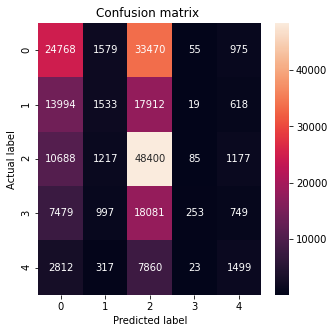

Text(0.5, 24.0, 'Predicted label')

In [0]:
# Se muestra matriz de confusión
cm1 = confusion_matrix(predict_test_pd["VAR_OBJETIVO"], predict_test_pd["prediction"])
plt.figure(figsize=(5,5))
sns.heatmap(cm1, annot=True, fmt="d")
plt.title('Confusion matrix ')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')